# Royal pubs in hex map

Using [h3 python library](https://github.com/uber/h3) from Uber

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import h3

from matplotlib import font_manager

#for colorbar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
%matplotlib inline

## Create hexagons based on GB shapefile

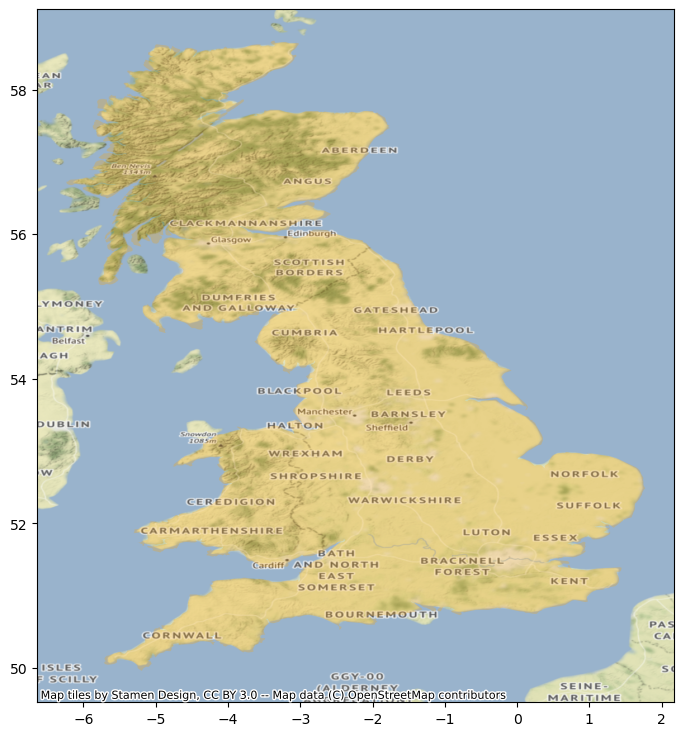

In [2]:
#Import the polygon for our area of interest with geopandas
sd = gpd.read_file("uk_polygon.geojson")

#Plot to check it's been correctly ingested
ax = sd.plot(alpha=0.25, color="orange", figsize=(9, 9))
cx.add_basemap(ax, crs=sd.crs.to_string())

In [3]:
#Get all polygons that intersect our area of interest
hexs = h3.polyfill(sd["geometry"].iloc[0].__geo_interface__, 5, geo_json_conformant = True)

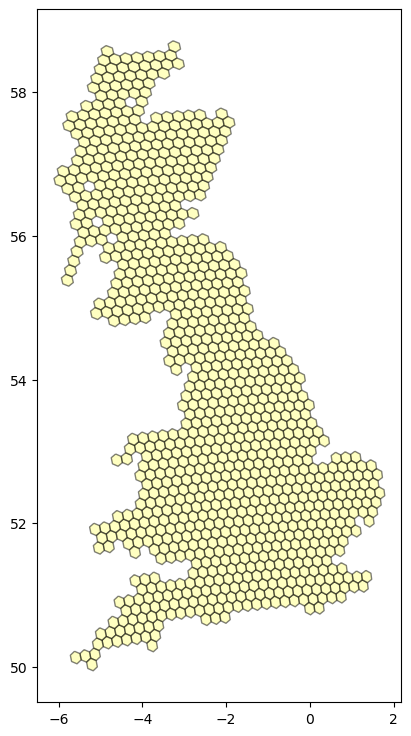

In [4]:
#Set up a simple lambda function that makes the geo_boundary call from a hex id
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

#Create a geodataframe and populate the geometrie field with the result of the polygonise function with the hexs variable for input
all_polys = gpd.GeoSeries(list(map(polygonise, hexs)), index=hexs, crs="EPSG:4326")
#all_polys = all_polys.to_crs(27700)

#Plot to see how it went
ax = all_polys.plot(alpha=0.5, color="xkcd:pale yellow",edgecolor="black", figsize=(9, 9))
#cx.add_basemap(ax, crs=all_polys.crs.to_string())

In [5]:
# convert to geodataframe to join with points data later
gdf_poly = gpd.GeoDataFrame(crs = 'EPSG:4326', geometry=all_polys)
gdf_poly = gdf_poly.reset_index().rename(columns={"index": "name"})
gdf_poly.head()

,name,geometry
0,85190887fffffff,"POLYGON ((-5.57899 57.12718, -5.69210 57.07848..."
1,85197363fffffff,"POLYGON ((-2.40512 55.15702, -2.51456 55.10978..."
2,8519546ffffffff,"POLYGON ((-4.21251 54.93311, -4.32120 54.88373..."
3,85192b37fffffff,"POLYGON ((-3.25272 57.61724, -3.36755 57.57149..."
4,851908abfffffff,"POLYGON ((-5.73701 56.86655, -5.84948 56.81743..."


## Get pubs from OpenStreetMap

In [6]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="GB"][admin_level=2]->.searchArea;
(node["amenity"="pub"](area.searchArea);
 way["amenity"="pub"](area.searchArea);
 rel["amenity"="pub"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [7]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [], "name":[],"brand":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["id"])
    
    for tag in ["name", "brand"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

In [8]:
#check if name contains queen or king
king = r"(\s|^)kings?($|\s|'|`)"
queen = r"(\s|^)queen?($|\s|'|`)"
df.loc[df["name"].str.lower().str.contains(king), "King"] = 1
df.loc[df["name"].str.lower().str.contains(queen), "Queen"] = 1

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_12968\2194046658.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df["name"].str.lower().str.contains(king), "King"] = 1
C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_12968\2194046658.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df["name"].str.lower().str.contains(queen), "Queen"] = 1


In [9]:
# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)
gdf.head()

,id,type,lat,lon,name,brand,King,Queen,geometry
0,262706,262706,51.035030,-0.725178,Kings Arms,,1.0,NaN,POINT (-0.72518 51.03503)
1,262708,262708,51.024400,-0.726258,Duke of Cumberland,,NaN,NaN,POINT (-0.72626 51.02440)
2,262709,262709,50.993224,-0.779150,Hamilton Arms,,NaN,NaN,POINT (-0.77915 50.99322)
3,262768,262768,50.979135,-0.813138,Elsted Inn,,NaN,NaN,POINT (-0.81314 50.97913)
4,262801,262801,50.969560,-0.883266,The White Hart,,NaN,NaN,POINT (-0.88327 50.96956)


## Choropleth map

In [10]:
# ==== DATA
# join dataframes and count number of pubs per polygon shape
gdf_join = gpd.sjoin(gdf, gdf_poly, how="right")
gdf_join = gdf_join.groupby("name_right").agg({"geometry":"first", "Queen": "sum", "King": "sum"})
gdf_join = gpd.GeoDataFrame(gdf_join, crs = 'EPSG:4326', geometry = gdf_join["geometry"])

gdf_outline = gpd.GeoDataFrame({'name': "GB", 'geometry': gdf_join.unary_union.boundary}, crs="EPSG:4326")

In [11]:
# ==== COLOURS
#create custom colourmap
from palettable.cmocean.sequential import Deep_12, Dense_16

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.1
maxColor = 1
new_cmap = truncate_colormap(plt.get_cmap(Dense_16.mpl_colormap), minColor, maxColor)
new_cmap

In [12]:
# ==== FONTS
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Balechin Royalo.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Roboto-Regular.ttf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Roboto-Regular.ttf')

#emojis
queen_img = plt.imread("https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/160/apple/325/princess_1f478.png")
king_img = plt.imread("https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/160/apple/325/prince_1f934.png")

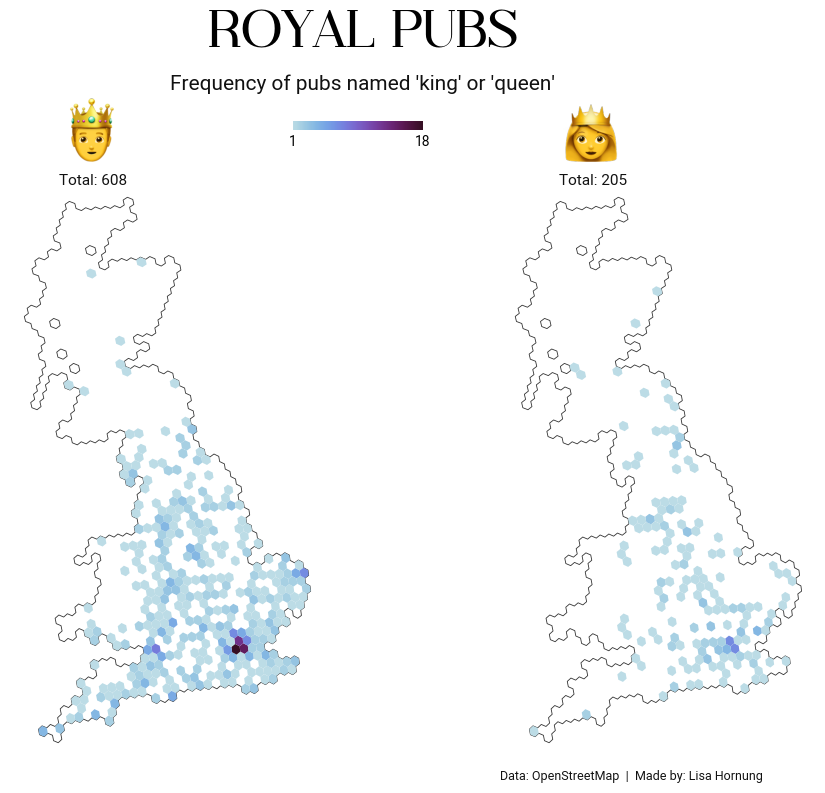

In [39]:
# ==== MAP

data = gdf_join.replace(0, np.nan) 
_max = max(gdf_join[["Queen", "King"]].max())

# setup
fig, ax = plt.subplots(figsize=(10,8), ncols=2, nrows=1)
plt.subplots_adjust(left=0.1, bottom=0.05, right=1, top=0.8, wspace=0.2, hspace=0.05)

## plot data
gdf_outline.plot(ax=ax[0], color="#333333", zorder=1, linewidth=0.6)
data.plot(ax=ax[0],  column="King", alpha=1, zorder=2, cmap=new_cmap, vmin=1, vmax=_max)
gdf_outline.plot(ax=ax[1], color="#333333", zorder=1, linewidth=0.6)
data.plot(ax=ax[1],  column="Queen", alpha=1, zorder=2, cmap=new_cmap, vmin=1, vmax=_max)

for axis in ax:
    axis.axis('off')

# colourbar
cbaxes = fig.add_axes([0.43, 0.85, 0.13, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=new_cmap)                      
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False, ticks=[0,1])
cb.ax.set_xticklabels(["1","18"], size=10, fontproperties=label_font)
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)

# ======
# Footer and title
plt.figtext(0.5,1, "Royal pubs".upper(), fontproperties = title_font, va='top', ha="center", fontsize=36)
plt.figtext(0.5,0.92, "Frequency of pubs named 'king' or 'queen'", fontproperties = subtitle_font, va='top', ha="center",
            fontsize=15, color="#111111")
plt.figtext(0.9,0.05, "Data: OpenStreetMap  |  Made by: Lisa Hornung", fontproperties = subtitle_font, 
            va='top', ha="right", fontsize=9, color="#111111")

# emojis
qax = fig.add_axes([0.68,0.81,0.08,0.08], anchor='NE', zorder=1)
qax.imshow(queen_img)
qax.axis('off')
plt.figtext(0.73,0.795, "Total: " + str(int(data["Queen"].sum())), 
            fontproperties = subtitle_font, va='top', ha="center", fontsize=11, color="#111111")

kax = fig.add_axes([0.18,0.81,0.08,0.08], anchor='NE', zorder=1)
kax.imshow(king_img)
kax.axis('off')
plt.figtext(0.23,0.795, "Total: " + str(int(data["King"].sum())), 
            fontproperties = subtitle_font, va='top', ha="center", fontsize=11, color="#111111")

#save
plt.savefig("british-royal-pubs.png", bbox_inches='tight',  transparent=False, pad_inches=0.4)

plt.show()

In [319]:
# average shape size in m2
(gdf_join.to_crs(3857).area / 1000).mean()

650754.5177802753

# Other explorations

Using renewable energy data

In [71]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np

## Prepare data

In [6]:
df = pd.read_excel("repd-october-2022.xlsx", sheet_name="REPD")

In [8]:
df["Technology Type"].value_counts()

Solar Photovoltaics                 3321
Wind Onshore                        2297
Battery                              888
Anaerobic Digestion                  302
Landfill Gas                         292
Biomass (dedicated)                  237
EfW Incineration                     197
Small Hydro                          140
Advanced Conversion Technologies     129
Wind Offshore                         81
Large Hydro                           30
Tidal Barrage and Tidal Stream        28
Hydrogen                              23
Sewage Sludge Digestion               12
Pumped Storage Hydroelectricity       11
Shoreline Wave                         8
Biomass (co-firing)                    5
Geothermal                             5
Liquid Air Energy Storage              4
Hot Dry Rocks (HDR)                    2
Compressed Air Energy Storage          2
Flywheels                              1
Fuel Cell (Hydrogen)                   1
Name: Technology Type, dtype: int64

In [31]:
# convert to geodataframe
geometry = [Point(xy) for xy in zip(df['X-coordinate'].astype(float), df['Y-coordinate'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:27700', geometry = geometry)
gdf = gdf.to_crs(epsg=4326)
gdf.head()

,Old Ref ID,Ref ID,Record Last Updated (dd/mm/yyyy),Operator (or Applicant),Site Name,Technology Type,Storage Type,Storage Co-location REPD Ref ID,Installed Capacity (MWelec),CHP Enabled,...,Appeal Granted,Planning Permission Granted,Secretary of State - Intervened,Secretary of State - Refusal,Secretary of State - Granted,Planning Permission Expired,Under Construction,Operational,Heat Network Ref,geometry
0,N00053B,1,2009-07-07,RWE npower,Aberthaw Power Station Biomass,Biomass (co-firing),NaN,NaN,35.0,No,...,NaT,2004-09-03,NaT,NaT,NaT,NaT,2006-05-01,2007-05-01,NaN,POINT (-3.40662 51.38747)
1,AA110,2,2017-11-20,Orsted (formerly Dong Energy) / Peel Energy,Hunterston - cofiring,Biomass (co-firing),NaN,NaN,170.0,No,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,POINT (-4.88855 55.73580)
2,B0730,3,2020-06-04,Scottish and Southern Energy (SSE),Ferrybridge Multifuel 2 (FM2),EfW Incineration,NaN,NaN,70.0,No,...,NaT,2015-10-28,NaT,NaT,NaT,2020-10-28,2016-09-01,2019-12-20,NaN,POINT (-1.28189 53.71644)
3,1106000,4,2003-12-18,Energy Power Resources,Thetford Biomass Power Station,Biomass (dedicated),NaN,NaN,38.5,No,...,NaT,1995-05-05,NaT,NaT,NaT,NaT,NaT,1998-10-02,NaN,POINT (0.72530 52.44865)
4,2047000,5,2005-09-29,Agrigen,Nunn Mills Road Biomass Plant,Biomass (dedicated),NaN,NaN,8.8,No,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,POINT (-0.88133 52.23021)


## Map

In [30]:
#load shapefile
regions_map = gpd.GeoDataFrame.from_file("uk_regions.geojson")

In [187]:
_filter = ( (gdf["Technology Type"]=="Solar Photovoltaics") &
      (gdf['Development Status (short)'].isin(["Awaiting Construction", "Operational"])))

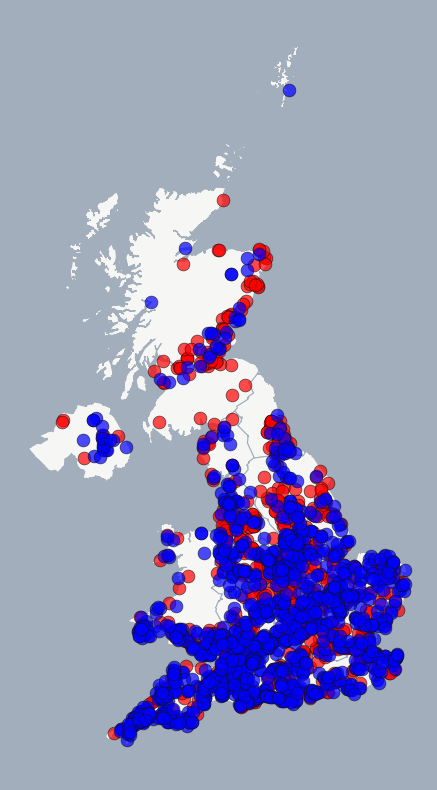

In [188]:
fig, ax = plt.subplots(figsize = (12,10))

#party colours
pointsPalette = {'Awaiting Construction': 'Red', 'Operational': 'Blue', 'Labour': '#DC241f'}
fig.set_facecolor("#A2AEBB")

### MAPS
#### UK
regions_map.to_crs(epsg=27700).plot(ax=ax, color='#f6f6f4', edgecolor='#A2AEBB', linewidth=0.75)
#df_uk = geo_df[~geo_df["Name"].isin(["Boris Johnson", "Bonar Law"])]

for ctype, data in gdf[_filter].to_crs(epsg=27700).groupby('Development Status (short)'):
    color = pointsPalette[ctype]
    label = ctype
    data.plot(color=color,
              ax=ax,
              label=label,
              markersize=85,
             edgecolor='#111111',
             linewidth=0.5,
             alpha=0.7)
ax.axis("off")
plt.show()

# Figuring out projections

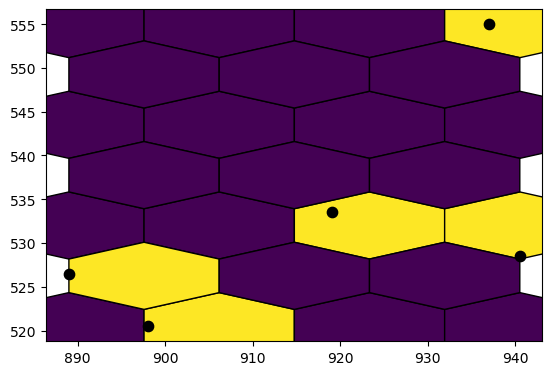

In [242]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from matplotlib.patches import RegularPolygon


geoms = [Point(919.000, 533.500), Point(940.500, 528.500), 
 Point(937.000, 555.000), Point(889.000, 526.500), Point(898.000, 520.500)]

l = gpd.GeoDataFrame({'geometry':geoms})

y= np.array([ 533.500,  528.500,  555.000,  526.500,  520.500])
x= np.array([ 919.000,  940.500,  937.000,  889.000,  898.000])

f,ax=plt.subplots(1)
im =ax.hexbin(x,y, gridsize=(3,3), edgecolor='black')
l.plot(ax=ax, color='black', markersize=55)

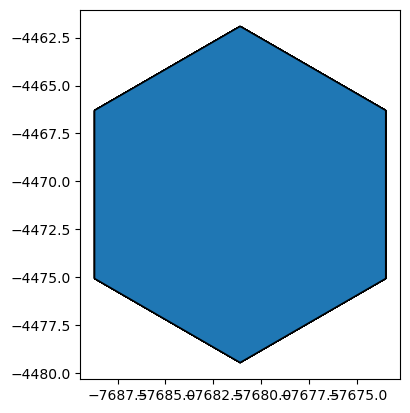

In [243]:
array_of_hexes=[]
for x,y in im.get_offsets():
    hexes = RegularPolygon((x, y), numVertices=6, radius= 5 )
    verts = hexes.get_path().vertices
    trans = im.get_transform()
    points = trans.transform(verts)
    array_of_hexes.append(Polygon(points))

gpd.GeoDataFrame({'geometry':array_of_hexes}).plot(edgecolor='black')

# Hexbin map using matplotlib

In [124]:
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def sized_hexbin(ax,hc,cmap, _max):
    offsets = hc.get_offsets()
    orgpath = hc.get_paths()[0]
    verts = orgpath.vertices
    values = hc.get_array()
    if _max == None:
        ma = values.max()
    else:
        ma = _max
    patches = []
    for offset,val in zip(offsets,values):
        v1 = verts*val/ma+offset
        path = Path(v1, orgpath.codes)
        patch = PathPatch(path)
        patches.append(patch)

    pc = PatchCollection(patches, cmap=cm.get_cmap(cmap), edgecolors='black')
    pc.set_array(values)
    ax.add_collection(pc)
    hc.remove()

In [146]:
import contextily as cx
import rasterio
from rasterio.plot import show as rioshow

In [182]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

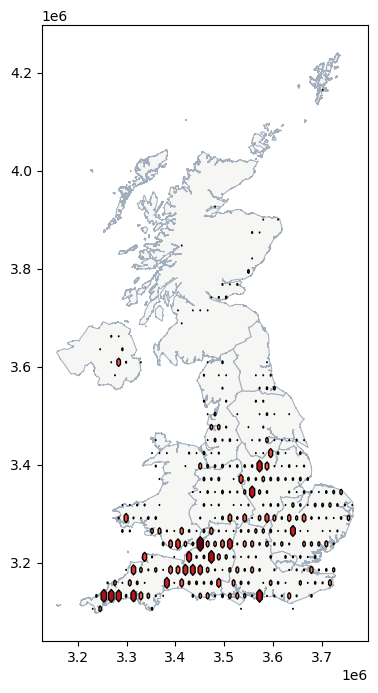

In [361]:
crs = 3035  
_filter = ( (gdf["Technology Type"]=="Solar Photovoltaics") &
      (gdf['Development Status (short)'].isin(["Operational"])))
test = gdf[_filter].to_crs(crs).dropna(subset=["X-coordinate", "Y-coordinate"])
test["Count"] = 1
test.head()

fig, ax = plt.subplots(figsize=(8,8))

regions_map.to_crs(epsg=crs).plot(ax=ax, color='#f6f6f4', edgecolor='#A2AEBB', linewidth=0.75)
hexbin = ax.hexbin(test["geometry"].x, test["geometry"].y, test["Count"] , reduce_C_function = np.sum, gridsize=35,
                   cmap= cm.get_cmap('Reds'),edgecolors='black')

sized_hexbin(ax,hexbin, "Reds", 19)

#ax.set_ylim(ymin=50, ymax=58)
plt.show()

In [164]:
#collection = plt.hexbin(x,y, gridsize=(5,5)
hex_polys = hexbin.get_paths()[0].vertices
hex_array = []
for xs,ys in hexbin.get_offsets():
    hex_x = np.add(hex_polys[:,0],  xs)
    hex_y = np.add(hex_polys[:,1],  ys)
    hex_array.append(Polygon(np.vstack([hex_x, hex_y]).T))

    
hex_grid = gpd.GeoDataFrame(crs = 'EPSG:4326', geometry = hex_array)

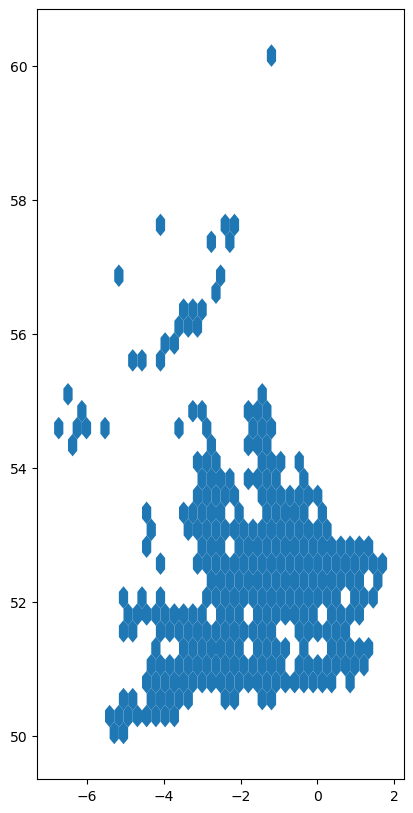

In [233]:
hex_grid.to_crs(4606).plot(figsize=(10,10))

In [163]:
hex_grid

,geometry
0,"POLYGON ((-6.61864 54.50946, -6.61864 54.67787..."
1,"POLYGON ((-6.37748 55.01470, -6.37748 55.18311..."
2,"POLYGON ((-6.13633 54.50946, -6.13633 54.67787..."
3,"POLYGON ((-5.89517 54.50946, -5.89517 54.67787..."
4,"POLYGON ((-5.41286 54.50946, -5.41286 54.67787..."
...,...
303,"POLYGON ((1.21891 52.23587, 1.21891 52.40428, ..."
304,"POLYGON ((1.21891 52.74111, 1.21891 52.90953, ..."
305,"POLYGON ((1.46006 51.22539, 1.46006 51.39380, ..."
306,"POLYGON ((1.46006 52.74111, 1.46006 52.90953, ..."


In [149]:
test["geometry"]

909        POINT (7684.998 7061685.216)
910     POINT (-538381.025 6504864.293)
911     POINT (-597584.558 6484100.232)
912     POINT (-476670.244 6523240.686)
913     POINT (-492826.132 6598355.891)
                     ...               
7072    POINT (-171540.872 7330689.045)
7217      POINT (95907.755 6900813.654)
7257     POINT (123480.225 6867796.952)
7501    POINT (-102324.182 6843809.609)
7502    POINT (-329217.745 6723483.292)
Name: geometry, Length: 1246, dtype: geometry

In [135]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [130]:
hexbin.get_array().max()

19.0

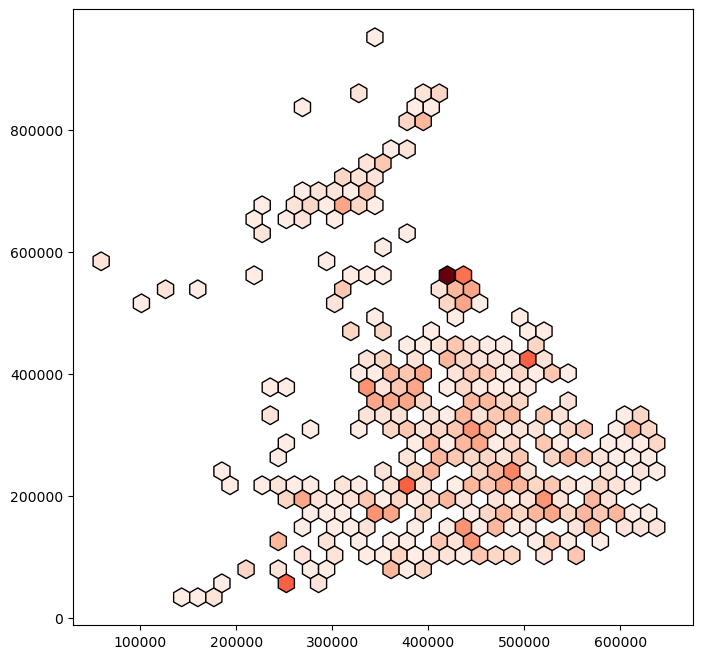

In [228]:
_filter = ( (gdf["Technology Type"]=="Solar Photovoltaics") &
      (gdf['Development Status (short)'].isin(["Awaiting Construction"])))
test = gdf[_filter].dropna(subset=["X-coordinate", "Y-coordinate"])
test["Count"] = 1
test.head()

fig, ax = plt.subplots(figsize=(8,8))
#hexbin = ax.hexbin(test['X-coordinate'], test['Y-coordinate'], test["Installed Capacity (MWelec)"], reduce_C_function = np.sum, 
               #    gridsize=35,cmap= cm.get_cmap('Reds'),edgecolors='black', vmin=0)

hexbin = ax.hexbin(test['X-coordinate'], test['Y-coordinate'], test["Count"] , reduce_C_function = np.sum, gridsize=35,
                   cmap= cm.get_cmap('Reds'),edgecolors='black', vmin=0, vmax=19)

#sized_hexbin(ax,hexbin, "Reds", 19)
plt.show()

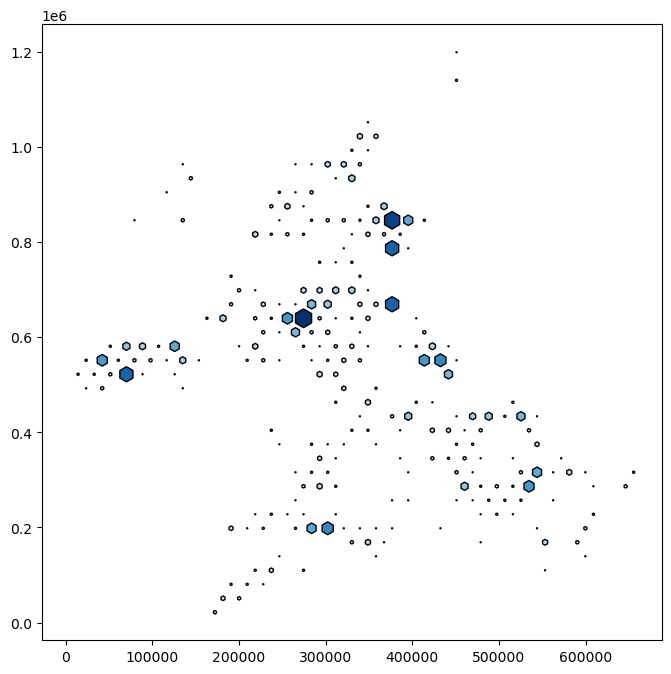

In [119]:
_filter = ( (gdf["Technology Type"]=="Wind Onshore") &
      (gdf['Development Status (short)'].isin(["Operational"])))
test = gdf[_filter].copy().dropna(subset=["X-coordinate", "Y-coordinate"])
test["Count"] = 1
test.head()

fig, ax = plt.subplots(figsize=(8,8))
#hexbin = ax.hexbin(test['X-coordinate'], test['Y-coordinate'], test["Installed Capacity (MWelec)"], reduce_C_function = np.sum, 
               #    gridsize=35,cmap= cm.get_cmap('Reds'),edgecolors='black', vmin=0)

hexbin = ax.hexbin(test['X-coordinate'], test['Y-coordinate'], test["Count"] , reduce_C_function = np.sum, gridsize=35,
                   cmap= cm.get_cmap('Blues'),edgecolors='black', vmin=0, vmax=hexbin.get_array().max())

sized_hexbin(ax,hexbin, "Blues")


plt.show()

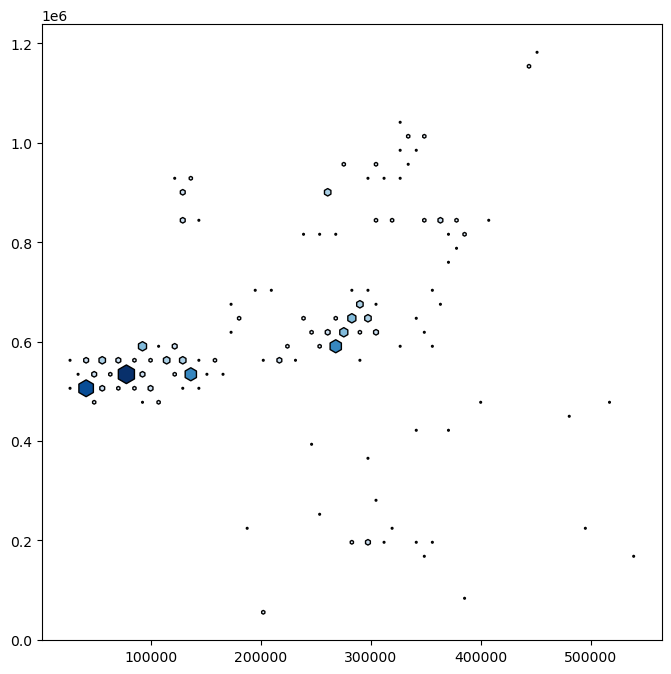

In [120]:
_filter = ( (gdf["Technology Type"]=="Wind Onshore") &
      (gdf['Development Status (short)'].isin(["Awaiting Construction"])))
test = gdf[_filter].copy().dropna(subset=["X-coordinate", "Y-coordinate"])
test["Count"] = 1
test.head()

fig, ax = plt.subplots(figsize=(8,8))
#hexbin = ax.hexbin(test['X-coordinate'], test['Y-coordinate'], test["Installed Capacity (MWelec)"], reduce_C_function = np.sum, 
               #    gridsize=35,cmap= cm.get_cmap('Reds'),edgecolors='black', vmin=0)

hexbin = ax.hexbin(test['X-coordinate'], test['Y-coordinate'], test["Count"] , reduce_C_function = np.sum, gridsize=35,
                   cmap= cm.get_cmap('Blues'),edgecolors='black', vmin=0, vmax=hexbin.get_array().max())

sized_hexbin(ax,hexbin, "Blues")


plt.show()

In [114]:
gdf["Technology Type"].value_counts()

Solar Photovoltaics                 3321
Wind Onshore                        2297
Battery                              888
Anaerobic Digestion                  302
Landfill Gas                         292
Biomass (dedicated)                  237
EfW Incineration                     197
Small Hydro                          140
Advanced Conversion Technologies     129
Wind Offshore                         81
Large Hydro                           30
Tidal Barrage and Tidal Stream        28
Hydrogen                              23
Sewage Sludge Digestion               12
Pumped Storage Hydroelectricity       11
Shoreline Wave                         8
Biomass (co-firing)                    5
Geothermal                             5
Liquid Air Energy Storage              4
Hot Dry Rocks (HDR)                    2
Compressed Air Energy Storage          2
Flywheels                              1
Fuel Cell (Hydrogen)                   1
Name: Technology Type, dtype: int64